In [30]:
import os
from tqdm import tqdm
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

import colorsys
from PIL import Image, ImageDraw, ImageFont


from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D
from keras.layers import BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import plot_model
from IPython.display import Image
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K   
import tensorflow as tf


In [31]:
ROOT_DIR = 'E:/raccoon_dataset-master'

DATA_PATH = os.path.join(ROOT_DIR, 'data')

#DATA_SET_PATH = os.path.join(DATA_PATH, 'raccoon')

ANNOTATIONS_PATH = os.path.join(ROOT_DIR, 'annotations/')

IMAGES_PATH = os.path.join(ROOT_DIR, 'images/')


In [32]:
map_classes = {0: 'raccoon'}

labels = list(map_classes.values())

In [33]:
LABELS = labels

IMAGE_H, IMAGE_W = 416, 416
GRID_H, GRID_W = 13, 13
BOX = 5
CLASS = len(LABELS)
CLASS_WEIGHTS = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3
ANCHORS = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
NO_OBJECT_SCALE = 1.0
OJECT_SCALE = 5.0
COORD_SCALE = 1.0
CLASS_SCALE = 1.0
BATCH_SIZE = 8
WARM_UP_BATCHS = 0
TRUE_BOX_BUFFER = 50

wt_path = 'E:/yolov2.weights'

train_image_folder = IMAGES_PATH
train_annot_folder = ANNOTATIONS_PATH
valid_image_folder = IMAGES_PATH
valid_annot_folder = ANNOTATIONS_PATH


In [34]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [35]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER, 4))

# layer 1
x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# layer 2
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# layer 3
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 4
x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 5
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# layer 6
x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 7
x = Conv2D(128, (1, 1), strides=(1, 1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 8
x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# layer 9
x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 10
x = Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 11
x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 12
x = Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 13
x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x
x = MaxPooling2D(pool_size=(2, 2))(x)

# layer 14
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 15
x = Conv2D(512, (1, 1), strides=(1, 1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 16
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 17
x = Conv2D(512, (1, 1), strides=(1, 1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 18
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 19
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 20
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 21
skip_connection = Conv2D(64, (1, 1), strides=(1, 1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# layer 22
x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)

output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
output = Lambda(lambda args: args[0])([output, true_boxes])

%matplotlib inline
model = Model([input_image, true_boxes], output)
model.summary()

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     

input_3 (InputLayer)            (None, 416, 416, 3)  0                                            

__________________________________________________________________________________________________

conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_3[0][0]                    

__________________________________________________________________________________________________

norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     

__________________________________________________________________________________________________

leaky_re_lu_23 (LeakyReLU)      (None, 416, 416, 32) 0           norm_1[0][0]                     

__________________________________________________________________________________________________

max_pooling2d_6 (MaxPooling2D)  (None, 208, 208, 32) 0           leaky_re_lu_23[0][0]             

__________________________________________________________________________________________________

conv_2 (Conv2D)                 (None, 208, 208, 64) 18432       max_pooling2d_6[0][0]            

__________________________________________________________________________________________________

norm_2 (BatchNormalization)     (None, 208, 208, 64) 256         conv_2[0][0]                     

__________________________________________________________________________________________________

leaky_re_lu_24 (LeakyReLU)      (None, 208, 208, 64) 0           norm_2[0][0]                     

__________________________________________________________________________________________________

max_pooling2d_7 (MaxPooling2D)  (None, 104, 104, 64) 0           leaky_re_lu_24[0][0]             

__________________________________________________________________________________________________

conv_3 (Conv2D)                 (None, 104, 104, 128 73728       max_pooling2d_7[0][0]            

__________________________________________________________________________________________________

norm_3 (BatchNormalization)     (None, 104, 104, 128 512         conv_3[0][0]                     

__________________________________________________________________________________________________

leaky_re_lu_25 (LeakyReLU)      (None, 104, 104, 128 0           norm_3[0][0]                     

__________________________________________________________________________________________________

conv_4 (Conv2D)                 (None, 104, 104, 64) 8192        leaky_re_lu_25[0][0]             

__________________________________________________________________________________________________

norm_4 (BatchNormalization)     (None, 104, 104, 64) 256         conv_4[0][0]                     

__________________________________________________________________________________________________

leaky_re_lu_26 (LeakyReLU)      (None, 104, 104, 64) 0           norm_4[0][0]                     

__________________________________________________________________________________________________

conv_5 (Conv2D)                 (None, 104, 104, 128 73728       leaky_re_lu_26[0][0]             

__________________________________________________________________________________________________

norm_5 (BatchNormalization)     (None, 104, 104, 128 512         conv_5[0][0]                     

__________________________________________________________________________________________________

leaky_re_lu_27 (LeakyReLU)      (None, 104, 104, 128 0           norm_5[0][0]                     

__________________________________________________________________________________________________

max_pooling2d_8 (MaxPooling2D)  (None, 52, 52, 128)  0           leaky_re_lu_27[0][0]             

__________________________________________________________________________________________________

conv_6 (Conv2D)                 (None, 52, 52, 256)  294912      max_pooling2d_8[0][0]            

__________________________________________________________________________________________________

norm_6 (BatchNormalization)     (None, 52, 52, 256)  1024        conv_6[0][0]                     

__________________________________________________________________________________________________

leaky_re_lu_28 (LeakyReLU)      (None, 52, 52, 256)  0           norm_6[0][0]                     

__________________________________________________________________________________________________

conv_7 (Conv2D)                 (None, 52, 52, 128)  32768       leaky_re_lu_28[0][0]             

__________________________________________________________________________________________________

norm_7 (BatchNormalization)     (None, 52, 52, 128)  512         conv_7[0][0]                     

__________________________________________________________________________________________________

leaky_re_lu_29 (LeakyReLU)      (None, 52, 52, 128)  0           norm_7[0][0]                     

__________________________________________________________________________________________________

conv_8 (Conv2D)                 (None, 52, 52, 256)  294912      leaky_re_lu_29[0][0]             

__________________________________________________________________________________________________

norm_8 (BatchNormalization)     (None, 52, 52, 256)  1024        conv_8[0][0]                     

__________________________________________________________________________________________________

leaky_re_lu_30 (LeakyReLU)      (None, 52, 52, 256)  0           norm_8[0][0]                     

__________________________________________________________________________________________________

max_pooling2d_9 (MaxPooling2D)  (None, 26, 26, 256)  0           leaky_re_lu_30[0][0]             

__________________________________________________________________________________________________

conv_9 (Conv2D)                 (None, 26, 26, 512)  1179648     max_pooling2d_9[0][0]            

__________________________________________________________________________________________________

norm_9 (BatchNormalization)     (None, 26, 26, 512)  2048        conv_9[0][0]                     

__________________________________________________________________________________________________

leaky_re_lu_31 (LeakyReLU)      (None, 26, 26, 512)  0           norm_9[0][0]                     

__________________________________________________________________________________________________

conv_10 (Conv2D)                (None, 26, 26, 256)  131072      leaky_re_lu_31[0][0]             

__________________________________________________________________________________________________

norm_10 (BatchNormalization)    (None, 26, 26, 256)  1024        conv_10[0][0]                    

__________________________________________________________________________________________________

leaky_re_lu_32 (LeakyReLU)      (None, 26, 26, 256)  0           norm_10[0][0]                    

__________________________________________________________________________________________________

conv_11 (Conv2D)                (None, 26, 26, 512)  1179648     leaky_re_lu_32[0][0]             

__________________________________________________________________________________________________

norm_11 (BatchNormalization)    (None, 26, 26, 512)  2048        conv_11[0][0]                    

__________________________________________________________________________________________________

leaky_re_lu_33 (LeakyReLU)      (None, 26, 26, 512)  0           norm_11[0][0]                    

__________________________________________________________________________________________________

conv_12 (Conv2D)                (None, 26, 26, 256)  131072      leaky_re_lu_33[0][0]             

__________________________________________________________________________________________________

norm_12 (BatchNormalization)    (None, 26, 26, 256)  1024        conv_12[0][0]                    

__________________________________________________________________________________________________

leaky_re_lu_34 (LeakyReLU)      (None, 26, 26, 256)  0           norm_12[0][0]                    

__________________________________________________________________________________________________

conv_13 (Conv2D)                (None, 26, 26, 512)  1179648     leaky_re_lu_34[0][0]             

__________________________________________________________________________________________________

norm_13 (BatchNormalization)    (None, 26, 26, 512)  2048        conv_13[0][0]                    

__________________________________________________________________________________________________

leaky_re_lu_35 (LeakyReLU)      (None, 26, 26, 512)  0           norm_13[0][0]                    

__________________________________________________________________________________________________

max_pooling2d_10 (MaxPooling2D) (None, 13, 13, 512)  0           leaky_re_lu_35[0][0]             

__________________________________________________________________________________________________

conv_14 (Conv2D)                (None, 13, 13, 1024) 4718592     max_pooling2d_10[0][0]           

__________________________________________________________________________________________________

norm_14 (BatchNormalization)    (None, 13, 13, 1024) 4096        conv_14[0][0]                    

__________________________________________________________________________________________________

leaky_re_lu_36 (LeakyReLU)      (None, 13, 13, 1024) 0           norm_14[0][0]                    

__________________________________________________________________________________________________

conv_15 (Conv2D)                (None, 13, 13, 512)  524288      leaky_re_lu_36[0][0]             

__________________________________________________________________________________________________

norm_15 (BatchNormalization)    (None, 13, 13, 512)  2048        conv_15[0][0]                    

__________________________________________________________________________________________________

leaky_re_lu_37 (LeakyReLU)      (None, 13, 13, 512)  0           norm_15[0][0]                    

__________________________________________________________________________________________________

conv_16 (Conv2D)                (None, 13, 13, 1024) 4718592     leaky_re_lu_37[0][0]             

__________________________________________________________________________________________________

norm_16 (BatchNormalization)    (None, 13, 13, 1024) 4096        conv_16[0][0]                    

__________________________________________________________________________________________________

leaky_re_lu_38 (LeakyReLU)      (None, 13, 13, 1024) 0           norm_16[0][0]                    

__________________________________________________________________________________________________

conv_17 (Conv2D)                (None, 13, 13, 512)  524288      leaky_re_lu_38[0][0]             

__________________________________________________________________________________________________

norm_17 (BatchNormalization)    (None, 13, 13, 512)  2048        conv_17[0][0]                    

__________________________________________________________________________________________________

leaky_re_lu_39 (LeakyReLU)      (None, 13, 13, 512)  0           norm_17[0][0]                    

In [36]:
%matplotlib inline
plot_model(model, to_file='yolo_v2-raccoon-dataset.png')
Image('yolo_v2-raccoon-dataset.png')

### Load weights provided by YOLO

In [37]:
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes


wight_reader = WeightReader(wt_path)
wight_reader.reset()

nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    # 在conv_1~conv_22的卷積組合裡都包含了"conv + norm"二層, 只有conv_23是獨立一層    
    if i < nb_conv: 
        print("handle norm_" + str(i) + " start")        
        norm_layer = model.get_layer('norm_' + str(i)) # 取得BatchNormalization層
        
        size = np.prod(norm_layer.get_weights()[0].shape) # 取得BatchNormalization層的參數量
        print("shape: ", norm_layer.get_weights()[0].shape)
        
        beta  = wight_reader.read_bytes(size)
        gamma = wight_reader.read_bytes(size)
        mean  = wight_reader.read_bytes(size)
        var   = wight_reader.read_bytes(size)
        weights = norm_layer.set_weights([gamma, beta, mean, var])
        print("handle norm_" + str(i) + " completed")
        
    if len(conv_layer.get_weights()) > 1:
        print("handle conv_" + str(i) + " start")  
        print("len:",len(conv_layer.get_weights()))
        bias   = wight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = wight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
        print("handle conv_" + str(i) + " completed")
    else:
        print("handle conv_" + str(i) + " start")        
        kernel = wight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2, 3, 1, 0])
        conv_layer.set_weights([kernel])
        print("handle conv_" + str(i) + " completed")
    


handle norm_1 start

shape: 

(32,)

handle norm_1 completed

handle conv_1 start

handle conv_1 completed

handle norm_2 start

shape: 

(64,)

handle norm_2 completed

handle conv_2 start

handle conv_2 completed

handle norm_3 start

shape: 

(128,)

handle norm_3 completed

handle conv_3 start

handle conv_3 completed

handle norm_4 start

shape: 

(64,)

handle norm_4 completed

handle conv_4 start

handle conv_4 completed

handle norm_5 start

shape: 

(128,)

handle norm_5 completed

handle conv_5 start

handle conv_5 completed

handle norm_6 start

shape: 

(256,)

handle norm_6 completed

handle conv_6 start

handle conv_6 completed

handle norm_7 start

shape: 

(128,)

handle norm_7 completed

handle conv_7 start

handle conv_7 completed

handle norm_8 start

shape: 

(256,)

handle norm_8 completed

handle conv_8 start

handle conv_8 completed

handle norm_9 start

shape: 

(512,)

handle norm_9 completed

handle conv_9 start

handle conv_9 completed

handle norm_10 start

shape: 

(256,)

handle norm_10 completed

handle conv_10 start

handle conv_10 completed

handle norm_11 start

shape: 

(512,)

handle norm_11 completed

handle conv_11 start

handle conv_11 completed

handle norm_12 start

shape: 

(256,)

handle norm_12 completed

handle conv_12 start

handle conv_12 completed

handle norm_13 start

shape: 

(512,)

handle norm_13 completed

handle conv_13 start

handle conv_13 completed

handle norm_14 start

shape: 

(1024,)

handle norm_14 completed

handle conv_14 start

handle conv_14 completed

handle norm_15 start

shape: 

(512,)

handle norm_15 completed

handle conv_15 start

handle conv_15 completed

handle norm_16 start

shape: 

(1024,)

handle norm_16 completed

handle conv_16 start

handle conv_16 completed

handle norm_17 start

shape: 

(512,)

handle norm_17 completed

handle conv_17 start

handle conv_17 completed

handle norm_18 start

shape: 

(1024,)

handle norm_18 completed

handle conv_18 start

handle conv_18 completed

handle norm_19 start

shape: 

(1024,)

handle norm_19 completed

handle conv_19 start

handle conv_19 completed

handle norm_20 start

shape: 

(1024,)

handle norm_20 completed

handle conv_20 start

handle conv_20 completed

handle norm_21 start

shape: 

(64,)

handle norm_21 completed

handle conv_21 start

handle conv_21 completed

handle norm_22 start

shape: 

(1024,)

handle norm_22 completed

handle conv_22 start

handle conv_22 completed

handle conv_23 start

len:

2

handle conv_23 completed

## Fine tune model's weights

In [38]:
layer = model.layers[-4]    # 提出最后一层的卷积层
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape) / (GRID_H * GRID_W)
new_bias   = np.random.normal(size=weights[1].shape) / (GRID_H * GRID_W)

layer.set_weights([new_kernel, new_bias])


## Train model

### Loss

In [39]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0, 2, 1, 3, 4))
    
    cell_grid = tf.tile(tf.concat([cell_x, cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    # Adjust prediction
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid  
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1, 1, 1, BOX, 2])
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    pred_box_class = y_pred[..., 5:]
    
    # Adjust ground truth
    true_box_xy = y_true[..., 0:2]
    true_box_wh = y_true[..., 2:4]
    
    true_wh_half = true_box_wh / 2.
    true_mins = true_box_xy - true_wh_half
    true_maxes = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins = pred_box_wh - pred_wh_half
    pred_maxes = pred_box_wh + pred_wh_half
    
    intersect_mins  = tf.maximum(pred_mins, true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]
    
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half
    
    intersect_mins  = tf.maximum(pred_mins, true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    conf_mask = conf_mask + y_true[..., 4] * OJECT_SCALE
    
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE
    
    
    # Warm-up training 
    
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE / 2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHS),
                            lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask,
                                     true_box_wh + tf.ones_like(true_box_wh) * 
                                     np.reshape(ANCHORS, [1, 1, 1, BOX, 2]) * no_boxes_mask,
                                     tf.ones_like(coord_mask)],
                            lambda: [true_box_xy,
                                     true_box_wh,
                                     coord_mask])
    
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy - pred_box_xy)     * coord_mask) / \
                                                                (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh - pred_box_wh)     * coord_mask) / \
                                                                (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf - pred_box_conf) * conf_mask)  / (nb_conf_box + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, 
                                                                logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * 
                                tf.to_float(pred_box_conf> 0.3))
    
    
    # Debugging code
    current_recall = nb_pred_box / (nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall)
    
    loss = tf.Print(loss, [tf.zeros((1))], message='Dummpy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss 

In [40]:
def normalize(image):
    return image / 255.

### BatchGenerator

In [41]:
generator_config = {
    'IMAGE_H'       : IMAGE_H,
    'IMAGE_W'       : IMAGE_W,
    'GRID_H'        : GRID_H,
    'GRID_W'        : GRID_W,
    'BOX'           : BOX,
    'LABELS'        : LABELS,
    'CLASS'         : len(LABELS),
    'ANCHORS'       : ANCHORS,
    'BATCH_SIZE'    : BATCH_SIZE,
    'TRUE_BOX_BUFFER': 50
}

train_imgs, seen_train_labels = parse_annotation(ANNOTATIONS_PATH, train_image_folder, labels=LABELS)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, 
                                                 labels=LABELS)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)



In [42]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.001,
                           patience=15,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint('weights_raccoon.h5', monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

In [43]:
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
# optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)



In [44]:
model.save('./yolov2_raccoon.h5')

In [45]:
history = model.fit_generator(generator = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 5, # 進行200個訓練循環
                    verbose          = 0,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint])



Epoch 00001: val_loss improved from inf to 1.39985, saving model to weights_raccoon.h5


Epoch 00002: val_loss improved from 1.39985 to 0.69918, saving model to weights_raccoon.h5


Epoch 00003: val_loss improved from 0.69918 to 0.69761, saving model to weights_raccoon.h5


Epoch 00004: val_loss improved from 0.69761 to 0.68956, saving model to weights_raccoon.h5


Epoch 00005: val_loss did not improve from 0.68956

## Detect Test

(1, 13, 13, 5, 6)

grid_h:

1

grid_w:

13

nb_box:

13

cnt=

1

box num:

1

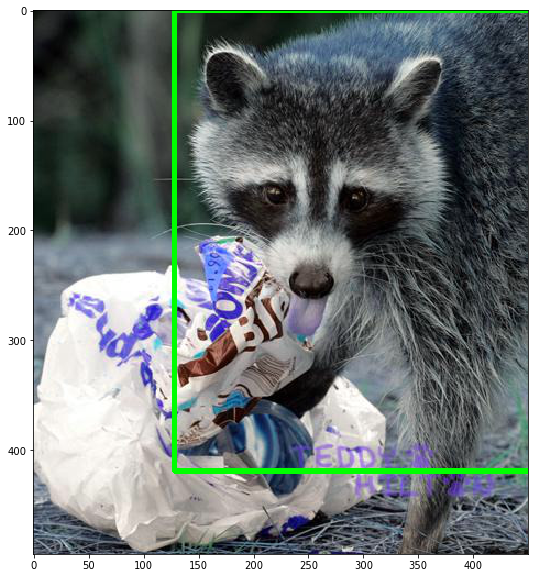

class number:

1

anchors:

[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

In [73]:
# from keras.models import load_model
# import tensorflow as tf
# model = load_model('yolov2_raccoon.h5')
model.load_weights('./weights_raccoon.h5')

dummy_array = np.zeros((1, 1, 1, 1, TRUE_BOX_BUFFER, 4))


img_filepath = train_imgs[np.random.randint(len(train_imgs))]['filename']

image = cv2.imread('E:/raccoon_dataset-master/images/raccoon-10.jpg')

plt.figure(figsize=(10, 10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

print(netout.shape)
grid_h, grid_w, nb_box = netout.shape[:3]

print('grid_h:', grid_h)
print('grid_w:', grid_w)
print('nb_box:', nb_box)


boxes = decode_netout(netout[0], 
                      obj_threshold=0.45,
                      nms_threshold=0.00005,
                      anchors=ANCHORS,
                      nb_class=CLASS)

image = draw_boxes(image, boxes, labels=LABELS)

cnt = 0
for box in boxes:
    cnt += 1
    
print('cnt=', cnt)

print('box num:', len(boxes))
#print('boxes[0]', boxes[0])
plt.imshow(image)
plt.show()

cv2.imshow('img', image)
cv2.waitKey(0)

print('class number:', CLASS)
print('anchors:', ANCHORS)